In [62]:
from pprint import pprint
import numpy as np 
import pandas as pd
from tqdm import tqdm
from utils import *
from functools import reduce

def eye_tracking_data_generator():
    data = load_nested_dict('data/Processed', ignore=IGNORE_NO_EYETRACKING) 
    for participant, _data1 in data.items(): #itertools.islice(data.items(), 1):
        for experiment, _data2 in _data1.items():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            eye_data = _data2['eye_tracking']
            gaze_data = eye_data['gaze'].to_numpy().astype(int)
            gaze_stats = {f'gaze at nothing' : 0}
            for task, window_properties in ALL_WINDOW_PROPERTIES.items():
                # for each eyetracking event, check if the participant is looking at the given task
                intaskbox = in_box(eye_data.x.to_numpy(), eye_data.y.to_numpy(), window_properties['position'], window_properties['size']) # 
                gazeintaskbox = np.logical_and(intaskbox, gaze_data)
                result = compute_time_intervals(gazeintaskbox, eye_data.timestamp.to_numpy(), start_time, finish_time)
                gaze_stats[f'gaze at {task}'] = result.proportion # individual stats for each task
                gaze_stats[f'gaze at nothing'] += result.proportion # total gaze at each
            result = compute_time_intervals(gaze_data, eye_data.timestamp.to_numpy(), start_time, finish_time)
            gaze_stats[f'gaze at any'] = result.proportion
            gaze_stats[f'gaze at nothing'] = result.proportion - gaze_stats[f'gaze at nothing']
            
            
            gaze_stats['gaze event count'] = int(gaze_data.sum().item())
            gaze_stats['succade event count'] = int((1-gaze_data).sum().item())
            gaze_stats['eye event count'] = gaze_data.shape[0]
            # number of groups of consequtive gaze events
            gaze_stats['gaze interval count'] = compute_num_groups_of_ones(gaze_data)
            
            # task switching 
            in_task = [in_box(eye_data.x.to_numpy(), eye_data.y.to_numpy(), props['position'], props['size']) for props in ALL_WINDOW_PROPERTIES.values()]
            in_task = [in_task[i].astype(int)*(i+1) for i in range(len(in_task))]
            in_task = reduce(lambda a,b:a+b, in_task)
            in_task = in_task[in_task > 0] # ignore the times where we go out then in the same task
            gaze_stats['task switch count'] = (in_task[:-1] != in_task[1:]).sum().item()
            
            
            # TODO we could also do this for mouse and keyboard input? 
            mouse_data = _data2['mouse']
            for task, data in mouse_data.groupby(mouse_data['task']):
                gaze_stats[f'click at {task}'] = data.shape[0]
            gaze_stats['click at any'] = mouse_data.shape[0]
            
            kdata = _data2['keyboard']
            gaze_stats['keyboard at tracking'] = kdata[kdata['action'] == 'press'].shape[0]

            yield dict(participant = participant, experiment = experiment[3:],
                       ** gaze_stats)
            
df = pd.DataFrame(eye_tracking_data_generator())
# merge performance measures so we might look at correlations
fp = Statistics.compute_failure_proportion_statistics()[['participant', 'experiment', 'total']]
fl = Statistics.compute_failure_length_statistics()[['participant', 'experiment', 'total']]
fc = Statistics.compute_failure_count_statistics()[['participant', 'experiment', 'total']]
df = pd.merge(df, fp.rename(columns={'total':'FP'}), on=['participant', 'experiment'])
df = pd.merge(df, fl.rename(columns={'total':'FL'}), on=['participant', 'experiment'])
df = pd.merge(df, fc.rename(columns={'total':'FC'}), on=['participant', 'experiment'])
df['difficulty'] = df['experiment'].str[-1]

# Remove rows where the eyetracking data is broken (effectively we are removing outliers here)
# Remember to normalise if comparing trials!!! 
df = df.drop(df[(df['participant'] == 'P05') & (df['experiment'] == 'icuB')].index)
df = df.drop(df[(df['participant'] == 'P07') & (df['experiment'] == 'icuaB')].index)
df = df.drop(df[(df['participant'] == 'P18') & (df['experiment'] == 'icuaA')].index)

dfA = df[df['difficulty'] == 'A']
dfB = df[df['difficulty'] == 'B']

print(df)

   participant experiment  gaze at nothing  gaze at system  gaze at fuel  \
0          P01       icuA         0.002775        0.055607      0.160456   
1          P01       icuB         0.000647        0.108267      0.162484   
2          P01      icuaA         0.005552        0.069394      0.125927   
3          P01      icuaB         0.004164        0.110116      0.168136   
4          P02       icuA         0.003794        0.080681      0.166271   
5          P02       icuB         0.012585        0.162581      0.049412   
6          P02      icuaA         0.011659        0.091513      0.209948   
7          P02      icuaB         0.016284        0.149612      0.073187   
8          P04       icuA         0.001110        0.059664      0.220952   
9          P04       icuB         0.002498        0.144841      0.219753   
10         P04      icuaA         0.000648        0.078746      0.291759   
11         P04      icuaB         0.000832        0.174048      0.274376   
12         P

   gaze at nothing  gaze at system  gaze at fuel  gaze at tracking
0         0.014829        0.134912      0.466835          0.383424
1         0.031461        0.276068      0.336488          0.355984
2         0.023298        0.137591      0.496447          0.342664
3         0.025158        0.285828      0.336673          0.352341


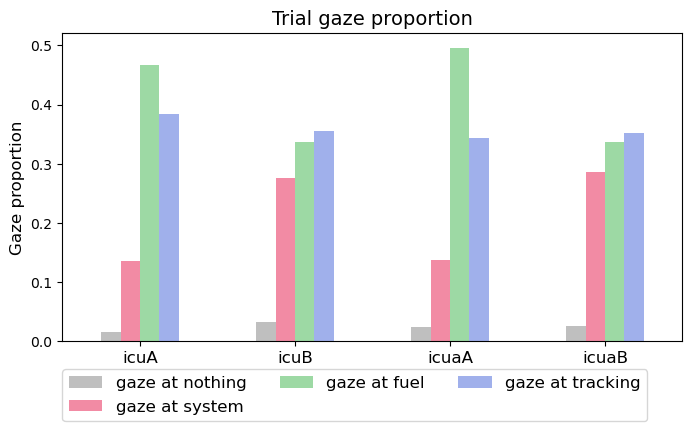

In [108]:
# PLOT FOR GAZE PROPORTIONS

# List to store summed values for each group
sums = []

# Iterate over each group and compute the sums
for _, group in df.groupby('experiment'):
    sums.append([
        group['gaze at nothing'].sum(),
        group['gaze at system'].sum(),
        group['gaze at fuel'].sum(),
        group['gaze at tracking'].sum()
    ])

# Convert sums list to a DataFrame for easier plotting
sums_df = pd.DataFrame(sums, columns=['gaze at nothing', 'gaze at system', 'gaze at fuel', 'gaze at tracking'])
sums_df = sums_df.div(sums_df.sum(axis=1), axis=0)
print(sums_df)
node_colors = ["grey", SYSTEM_COLOR, FUEL_COLOR, TRACKING_COLOR]

# Plot
sums_df.plot(kind='bar', stacked=False, figsize=(8, 4), color=node_colors, alpha=0.5)

# Customize the plot
plt.title('Trial gaze proportion', fontsize=14)
plt.ylabel('Gaze proportion', fontsize=12)
plt.xticks(range(len(sums_df)), df['experiment'].unique(), rotation=0, fontsize=12)  # set x-tick labels to experiment names
plt.legend(loc=(-0.0,-0.26), ncols=3, prop={'size': 12})
#plt.tight_layout()

plt.savefig("./results/trial-gaze-proportion.png", bbox_inches="tight")

plt.show()




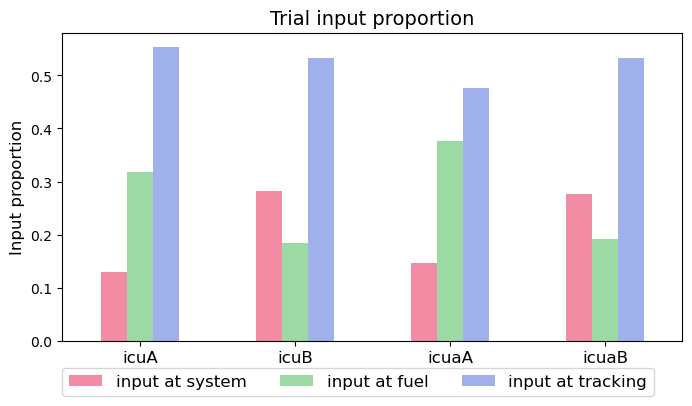

In [106]:
# PLOT FOR GAZE PROPORTIONS

# List to store summed values for each group
sums = []

# Iterate over each group and compute the sums
for _, group in df.groupby('experiment'):
    sums.append([
        group['click at system'].sum(),
        group['click at fuel'].sum(),
        group['keyboard at tracking'].sum()
    ])

# Convert sums list to a DataFrame for easier plotting
sums_df = pd.DataFrame(sums, columns=['input at system', 'input at fuel', 'input at tracking'])
sums_df = sums_df.div(sums_df.sum(axis=1), axis=0)

node_colors = [SYSTEM_COLOR, FUEL_COLOR, TRACKING_COLOR]

# Plot
sums_df.plot(kind='bar', stacked=False, figsize=(8, 4), color=node_colors, alpha=0.5)

# Customize the plot
plt.title('Trial input proportion', fontsize=14)
plt.ylabel('Input proportion', fontsize=12)
plt.xticks(range(len(sums_df)), df['experiment'].unique(), rotation=0,  fontsize=12)  # set x-tick labels to experiment names
plt.legend(loc=(0.,-0.18), ncols=4, prop={'size': 12})
#plt.tight_layout()

plt.savefig("./results/trial-input-proportion.png", bbox_inches="tight")

plt.show()



In [107]:
# PLOT FOR GAZE PROPORTIONS

# List to store summed values for each group
sums = []

# Iterate over each group and compute the sums
for _, group in df.groupby('experiment'):
    sums.append([
        group['task switch count'].sum(),
    ])

# Convert sums list to a DataFrame for easier plotting
sums_df = pd.DataFrame(sums, columns=['input at system', 'input at fuel', 'input at tracking'])
sums_df = sums_df.div(sums_df.sum(axis=1), axis=0)

node_colors = [SYSTEM_COLOR, FUEL_COLOR, TRACKING_COLOR]

# Plot
sums_df.plot(kind='bar', stacked=False, figsize=(8, 4), color=node_colors, alpha=0.5)

# Customize the plot
plt.title('Trial input proportion', fontsize=14)
plt.ylabel('Input proportion', fontsize=12)
plt.xticks(range(len(sums_df)), df['experiment'].unique(), rotation=0,  fontsize=12)  # set x-tick labels to experiment names
plt.legend(loc=(0.,-0.18), ncols=4, prop={'size': 12})
#plt.tight_layout()

plt.savefig("./results/trial-input-proportion.png", bbox_inches="tight")

plt.show()


ValueError: 3 columns passed, passed data had 1 columns

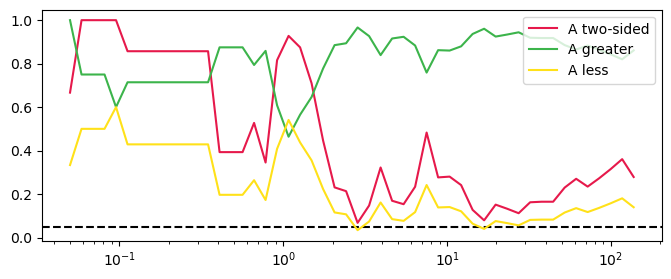

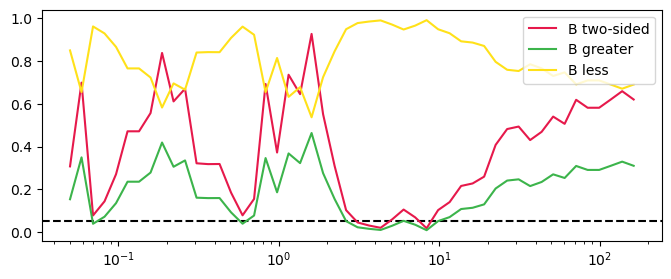

In [132]:
# comparing failure interval length (FIL) distributions 

from pprint import pprint
from datetime import datetime
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
from utils import *
from utils import markdown
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
    
def data_iterator():
    data = load_nested_dict('data/Processed', ignore=IGNORE_NO_EYETRACKING)
    for i, (participant, _data1) in enumerate(data.items()):
        for j, (experiment, _data2) in enumerate(_data1.items()):
            yield (i, participant), (j, experiment[3:]), _data2

def compute_failure_proportion_intervals():
    data = load_nested_dict('data/Processed')
    def _gen():
        for (_, participant), (_, experiment), _data2 in data_iterator():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            for task, _data3 in sorted(_data2['tasks'].items()):
                failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
                failure_intervals = merge_intervals(failure_intervals) - start_time # merge them to get failures for a single task
                if len(failure_intervals) > 0:
                    yield np.full(failure_intervals.shape[0], participant), np.full(failure_intervals.shape[0], experiment), np.full(failure_intervals.shape[0], task), failure_intervals[:,0], failure_intervals[:,1]
    data = [np.concatenate(x, axis=0) for x in zip(*_gen())]
    data = dict(zip(['participant', 'experiment', 'task', 't1', 't2'], data))
    return pd.DataFrame(data)
fp = compute_failure_proportion_intervals()
fp['score'] = fp['t2'] - fp['t1']
df = fp
sA, saA = df[df['experiment'] == 'icuA'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaA'].sort_values('participant').reset_index(drop=True)
sB, saB = df[df['experiment'] == 'icuB'].sort_values('participant').reset_index(drop=True), df[df['experiment'] == 'icuaB'].sort_values('participant').reset_index(drop=True)

def check_limits(x, xa, lims, alternative='two-sided', use_continuity=True, label="", ax=None):
    ps = []
    for lim in lims:
        _x = x[x['score'] < lim]
        _xa = xa[xa['score'] < lim]
        result = stats.mannwhitneyu(_x['score'], _xa['score'], alternative=alternative, use_continuity=use_continuity)
        ps.append(result.pvalue)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.plot(lims, ps, label=f"{label} {alternative}")
    
plt.figure(figsize=(8,3))
ax = plt.gca()
ax.axhline(0.05, linestyle="--", color="black")
ax.set_xscale('log')

Alims = np.logspace(np.log10(0.05), np.log10(max(sA['score'].max(), saA['score'].max())), 50)
check_limits(sA, saA, lims=Alims, ax=ax, label="A")
check_limits(sA, saA, lims=Alims, ax=ax, label="A", alternative="greater")
check_limits(sA, saA, lims=Alims, ax=ax, label="A", alternative="less")
plt.legend(loc="upper right")

plt.figure(figsize=(8,3))
ax = plt.gca()
ax.axhline(0.05, linestyle="--", color="black")
ax.set_xscale('log')

Blims = np.logspace(np.log10(0.05), np.log10(max(sB['score'].max(), saB['score'].max())), 50)
check_limits(sB, saB, lims=Blims, ax=ax, label="B")
check_limits(sB, saB, lims=Blims, ax=ax, label="B", alternative="greater")
check_limits(sB, saB, lims=Blims, ax=ax, label="B", alternative="less")
plt.legend(loc="upper right")

# mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'])
# mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'])
# print(f"A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
# print(f"B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

# mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'], alternative="greater")
# mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'], alternative="greater")
# print(f"Greater A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
# print(f"Greater B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")

# mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'], alternative="greater", use_continuity=True)
# mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'], alternative="greater", use_continuity=True)
# print(f"Greater uc A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
# print(f"Greater uc B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")


# mannwhitneyuA = stats.mannwhitneyu(sA['score'], saA['score'], alternative="less")
# mannwhitneyuB = stats.mannwhitneyu(sB['score'], saB['score'], alternative="less")
# print(f"Lesser A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
# print(f"Lesser B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")


0.010964942932128907


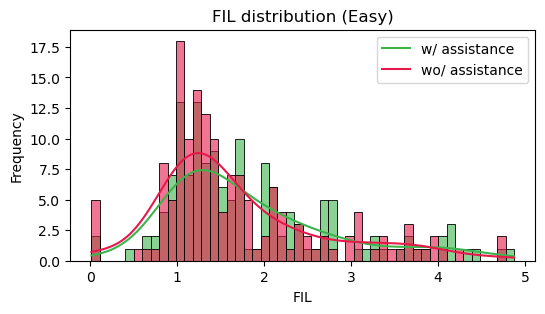

0.001


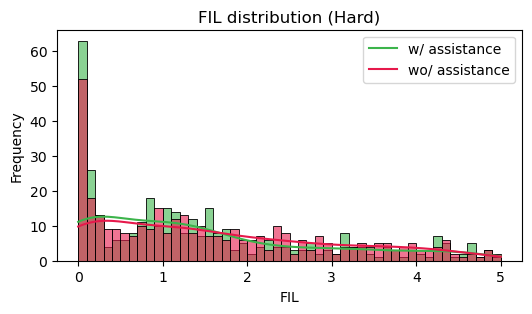

In [135]:

def plot_hist(data, logx=False, logy=False, title=None):
    # Combine the two datasets into a single DataFrame (optional, if you have separate DataFrames)
    _df = pd.DataFrame(data)
    _df = _df + 1e-3
    df_min, df_max = _df.min().min(), _df.max().max()
    print(df_min)
    bins = np.logspace(np.log10(df_min), np.log10(df_max), 50) if logx else 50
    fig = plt.figure(figsize=(6,3))
    sns.histplot(data=_df, kde=True, alpha=0.6, bins=bins)
    plt.legend(data.keys(), loc="upper right")
    plt.xlabel('FIL')
    plt.ylabel('Log frequency' if logy else 'Frequency')
    plt.title(title)
    if logx:
        plt.gca().set_xscale('log')
    if logy:
        plt.gca().set_yscale('log')
    
    
    plt.show()

lim = 5
sA = sA[sA['score'] < lim]
saA = saA[saA['score'] < lim]

sB = sB[sB['score'] < lim]
saB = saB[saB['score'] < lim]

plot_hist({'w/ assistance': sA['score'], 'wo/ assistance': saA['score']}, logy=False, title="FIL distribution (Easy)")
plot_hist({'w/ assistance': sB['score'], 'wo/ assistance': saB['score']}, logy=False, title="FIL distribution (Hard)")
